In [1]:
import pandas as pd
import numpy as np
from pandas.io.json import json_normalize
import nltk
import re
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

In [2]:
text_data = pd.read_json("data/texts.json")

data hodime do dataframu a vyhodime tie co neobsahuju text

In [3]:
import json

nltk.download('punkt')

raw_data = []


def get_topics(item):
    if not item['_TOPICS'] == 'YES' or item['TOPICS'] == '':
        return None
    if isinstance(item['TOPICS'], str):
        print(item['TOPICS'])
        topics_obj = json.loads(item['TOPICS'])
    else:
        topics_obj = item['TOPICS']
    return [topics_obj['D']] if isinstance(topics_obj['D'], str) else topics_obj['D']
        

text_data['text'] = text_data.REUTERS.map(lambda item: None if 'BODY' not in item['TEXT'] else item['TEXT']['BODY'])
text_data['topics'] = text_data.REUTERS.map(get_topics)
text_data = text_data[text_data['text'].notna()]

[nltk_data] Downloading package punkt to /Users/sajmon/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


stokenizujeme text (skusali sme ci je rozdiel medzi spacy a nltk tokenami, ale nie je ziadny viditelny)

In [4]:
from spacy.lang.en import English
import nltk

nlp = English()


def get_text_from_tokens(tokens):
    return [t.text for t in tokens]

text_data['tokens_spacy'] = text_data['text'].map(lambda t: get_text_from_tokens(nlp(t)))
text_data['tokens_nltk'] = text_data['text'].map(lambda t: nltk.word_tokenize(t))


natrenujeme doc2vec

In [98]:
articles = [TaggedDocument(doc, [i]) for i, doc in enumerate(text_data['tokens_spacy'])]
article_model = Doc2Vec(articles, vector_size=10, window=5, min_count=4, workers=4)
article_vectors = list(map(article_model.infer_vector, text_data['tokens_spacy']))

zredukujeme dimenzie

In [99]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
pca_result = pca.fit_transform(article_vectors)
x_pca = pca_result[:,0]
y_pca = pca_result[:,1]
z_pca = pca_result[:,2]

text_data['x'] = x_pca
text_data['y'] = y_pca

articles_3d = pd.DataFrame(data={
    'x': (x_pca-min(x_pca))/(max(x_pca)-min(x_pca)),
    'y':(y_pca-min(y_pca))/(max(y_pca)-min(y_pca)),
    'z': (z_pca-min(z_pca))/(max(z_pca)-min(z_pca))
})

vizualizujeme 2d

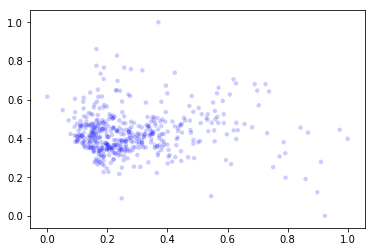

In [100]:
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt

ax = plt.axes()

ax.scatter(articles_3d['x'], articles_3d['y'], alpha=0.2, c='blue', edgecolors='none', s=20)

vizualizujeme 3d

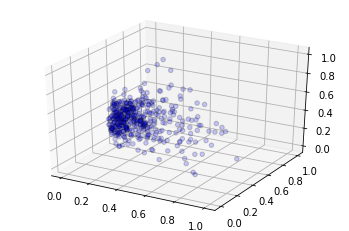

In [9]:
ax = plt.axes(projection='3d')

ax.scatter(articles_3d['x'], articles_3d['y'], articles_3d['z'], alpha=0.2, c='blue', edgecolors='none', s=20)
# ax.view_init(30, 40)

In [10]:
def visualize_clusters(df,x,y, cluster_id):
    ax1 = plt.axes()
    colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan']
    for i in range(0,9):
        ax1.scatter(
            df[x][df[cluster_id].astype('int') == i], 
            df[y][df[cluster_id].astype('int') == i], 
            alpha=1, c=colors[i],
            s=3, 
            label=i)
    ax1.scatter(
            df[x][df[cluster_id].astype('int') > 9], 
            df[y][df[cluster_id].astype('int') > 9], 
            alpha=1, c='black',
            s=3, 
            label=i)
    

sklastrujeme pomocou kmeans

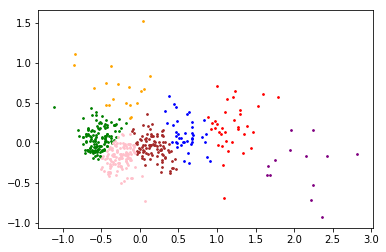

In [68]:
from sklearn.cluster import KMeans, MeanShift, DBSCAN

kmeans = KMeans(n_clusters=7, random_state=420).fit(article_vectors)


text_data['k_means_predicted'] = kmeans.labels_
visualize_clusters(text_data, 'x', 'y', 'k_means_predicted')

vypiseme nejake dokumenty z clusterov a zistime ci sa niecim podobaju

In [65]:
for item in text_data[text_data.k_means_predicted==1].text[:10]:
    print(item)
    print()
    print('==========')
    print()

Shr 75 cts vs 55 cts
    Net 8,031,000 vs 5,819,000
    Nine mths
    Shr 2.16 dlrs vs 1.42 dlrs
    Net 23.2 mln vs 15.1 mln
    Assets 3.41 billion vs 2.84 billion
    Deposits 2.54 billion vs 2.19 billion
    NOTE: 1987 nine mths includes gain 1,008,000 dlrs, or nine
cts per share, from utilization of prior year's net operating
loss carryforwards.
   
    NOTE: 1986 qtr and nine mths include loss 131,000 dlrs, or
one cent per share, from unspecified extraordinary item.
    1986 qtr and nine mths includes gain 2,281,000 dlrs, or 22
cts per share, and 6,393,000 dlrs, or 60 cts per share,
respectively, from utilization of net operating loss
carryforwards.
    full name of company is society for savings bancorp inc.
 Reuter


Oper shr 17 cts vs not available
    Oper net 1,619,000 vs 6,354,000
    Nine Mths
    Oper shr 80 cts vs not available
    Oper net 7,675,000 vs 22,669,000
    Assets 6.06 billion vs 5.74 billion
    Loans 3.11 billion vs 3.33 billion
    Deposits 4.57 billion vs 

In [104]:
for item in text_data[text_data.k_means_predicted==2].text[:10]:
    print(item)
    print()
    print('==========')
    print()

Qtly div 27-1/2 cts vs 27-1/2 cts prior
    Pay December 31
    Record December Four
 Reuter


Shr 96 cts vs 87 cts
    Net 10.8 mln vs 9,671,000
    Revs 103.9 mln vs 97.5 mln
    Nine mths
    Shr 2.73 dlrs vs 2.62 dlrs
    Net 30.7 mln vs 29.3 mln
    Revs 325.7 mln vs 302.8 mln
 Reuter


Shr 64 cts vs 55 cts
    Net 14.0 mln vs 11.8 mln
    Nine mths
    Shr 1.83 dlrs vs 1.53 dlrs
    Net 39.7 mln vs 32.7 mln
    Assets 4.65 billion vs 4.53 billion
    Loans 3.24 billion vs 2.92 billion
    Deposits 3.32 billion vs 3.15 billion
 Reuter


Shr 30 cts vs 30 cts
    Net 1,804,000 vs 1,800,000
    Nine mths
    Shr 89 cts vs 79 cts
    Net 5,334,00 vs 4,496,000
    NOTE: Earnings per share reflect initial public offering of
534,750 common shares in March 1986 and 2-for-1 stock splits in
January and June 1986.
 Reuter


Shr 30 cts vs 26 cts
    Net 2,534,000 vs 1,695,000
    Revs 98.8 mln vs 67.1 mln
    Avg shrs 8,447,000 vs 6,563,000
    NOTE: full name of company is harman internation

In [105]:
for item in text_data[text_data.k_means_predicted==3].text[:10]:
    print(item)
    print()
    print('==========')
    print()

The Canadian Auto Workers' Union said it
accepted an economic offer from the Canadian division of
General Motors Corp GM> in contract negotiations.
    But union president Bob White said many local issues at the
11 plants in Ontario and Quebec still remained unresolved ahead
of Thursday's deadline for a strike by 40,000 workers.
    "It minimizes the possibility of a strike," White told
reporters.
    However, "if we don't have local agreements settled by
Thursday, there will be a strike," he said.
    The local issues still unresolved involved health care,
skilled trades and job classifications, White said.
    GM Canada negotiator Rick Curd said he believed a strike
would be avoided.
    "Even though there are some tough issues to be resolved
we're on the right schedule to meet the target," Curd said.
    "I'm very pleased with the state of the negotiations," he
said.
    Union membership meetings have been scheduled for the
weekend in case a tentative settlement, said White.
    Whi

V ramci jednotlivych clustrov vidno zvacsa podobnosti.

kedze jeden dokument ma array topicov, potrebujeme dostat flat strukturu

In [16]:
# kod z netu

def split_data_frame_list(df, 
                       target_column,
                      output_type=float):
    ''' 
    Accepts a column with multiple types and splits list variables to several rows.

    df: dataframe to split
    target_column: the column containing the values to split
    output_type: type of all outputs
    returns: a dataframe with each entry for the target column separated, with each element moved into a new row. 
    The values in the other columns are duplicated across the newly divided rows.
    '''
    row_accumulator = []

    def split_list_to_rows(row):
        split_row = row[target_column]
        if isinstance(split_row, list):
            for s in split_row:
                new_row = row.to_dict()
                new_row[target_column] = output_type(s)
                row_accumulator.append(new_row)
        else:
            new_row = row.to_dict()
            new_row[target_column] = output_type(split_row)
            row_accumulator.append(new_row)
  
    df.apply(split_list_to_rows, axis=1)
    new_df = pd.DataFrame(row_accumulator)
  
    return new_df

In [17]:
text_split_topics = split_data_frame_list(text_data, 'topics', str)

zistime completness score

In [106]:
from sklearn.metrics import completeness_score

text_split_topics = text_split_topics[text_split_topics['topics'] != 'None' ]
text_split_topics
completeness_score(text_split_topics['topics'], text_split_topics['k_means_predicted'])

0.45466655156922314

In [107]:
import seaborn as sns

vizualizujeme rozlozenie jednotlivych tem cez topicy

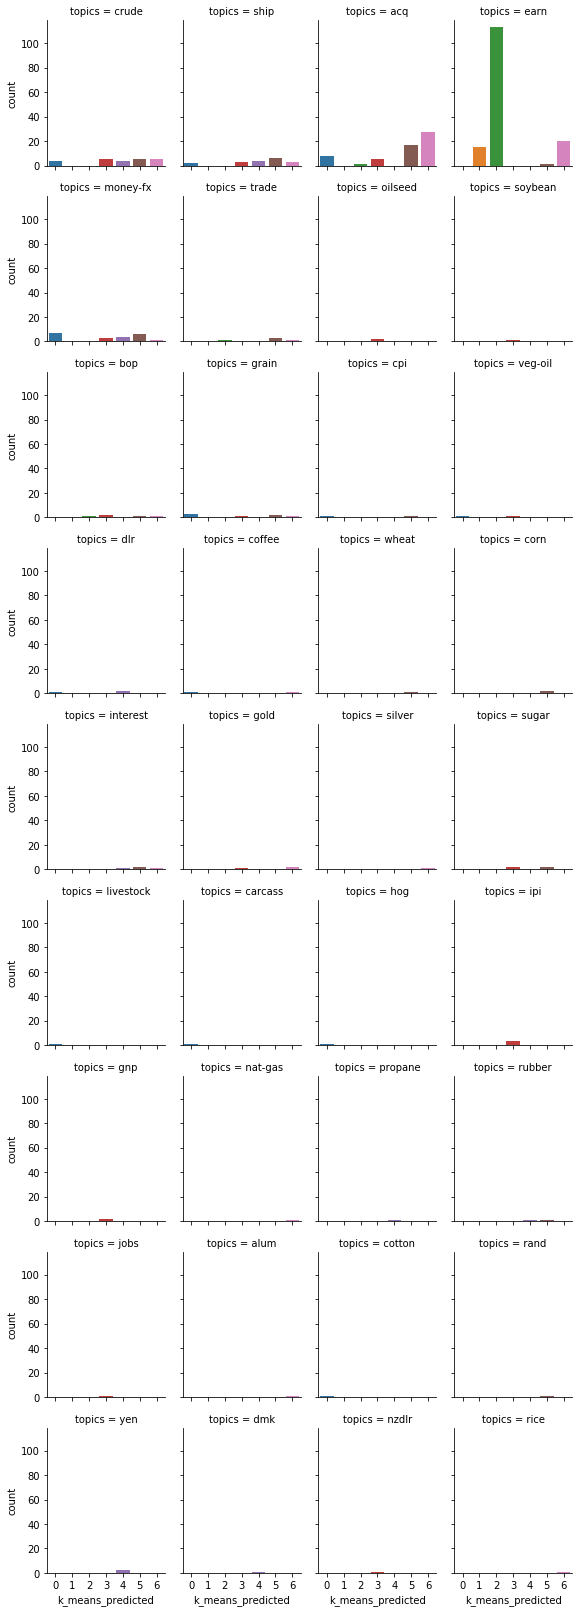

In [40]:
sns.catplot("k_means_predicted", col="topics", col_wrap=4, data=text_split_topics, kind="count", height=2.5, aspect=.8)
# fig, axarr = subplots(7, figsize=(15, 17))
# axarr[0].(img20, interpolation="nearest")  

skusime sclustrovat meanshiftom

0.335035085757658


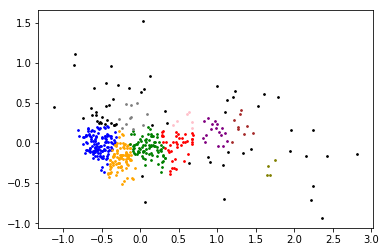

In [63]:
meanshift = MeanShift(bandwidth=0.2).fit(article_vectors)


text_data['meanshift_predicted'] = meanshift.labels_
text_split_topics = split_data_frame_list(text_data, 'topics', str)
visualize_clusters(text_data, 'x', 'y','meanshift_predicted')
print(completeness_score(text_split_topics['topics'], text_split_topics['meanshift_predicted']))

na vizualizacii vyzeraju clustre celkom pekne, avsak completness score sa znizilo

skusime dbscan

0.38474364653646803


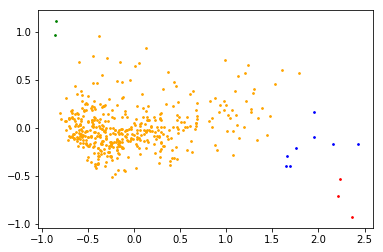

In [97]:
dbscan = DBSCAN(eps=0.3, min_samples=2).fit(article_vectors)

text_data['dbscan_predicted'] = dbscan.labels_
text_split_topics = split_data_frame_list(text_data, 'topics', str)
visualize_clusters(text_data, 'x', 'y','dbscan_predicted')
print(completeness_score(text_split_topics['topics'], text_split_topics['dbscan_predicted']))

dbscan dopadol dost zle s hociakym parametrami